In [10]:
#import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier # New Model 1
from sklearn.ensemble import RandomForestClassifier # New Model 2
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree




In [2]:
from google.colab import files
uploaded = files.upload()



Saving Titanic-Dataset.csv to Titanic-Dataset.csv


In [3]:
#read the csv
df = pd.read_csv('Titanic-Dataset.csv')
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [4]:
#check for null values
df.isnull().sum()

,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,177
SibSp,0
Parch,0
Ticket,0
Fare,0


In [5]:
#Handling missing values
# --- AGE: Impute grouped medians ---
df['Age'] = df.groupby(['Pclass', 'Sex'])['Age'].transform(lambda x: x.fillna(x.median()))

# --- EMBARKED: Fill with mode ---
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)

# --- CABIN: Create binary indicator then drop cabin ---
df['HasCabin'] = df['Cabin'].notnull().astype(int)
df.drop('Cabin', axis=1, inplace=True)

# Check again
print(df.isnull().sum())

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
HasCabin       0
dtype: int64


/tmp/ipython-input-3314548816.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)


In [6]:
# --- 1. ADVANCED FEATURE ENGINEERING  ---

# A. Title Extraction from 'Name'
def get_title(name):
    """Extracts the title (e.g., 'Mr', 'Miss') from a full name."""
    title_search = re.search(' ([A-Za-z]+)\.', name)
    return title_search.group(1) if title_search else ""

df['Title'] = df['Name'].apply(get_title)

# Group rare titles into common categories
rare_titles = ['Don', 'Rev', 'Dr', 'Major', 'Lady', 'Sir', 'Col', 'Capt', 'Countess', 'Jonkheer']
df['Title'] = df['Title'].replace(rare_titles, 'Rare')
df['Title'] = df['Title'].replace(['Mlle', 'Ms'], 'Miss')
df['Title'] = df['Title'].replace('Mme', 'Mrs')


# B. Fare Binning
# Convert continuous 'Fare' into 4 ordinal bins (Low, Med, High, VeryHigh)
df['FareBin'] = pd.cut(df['Fare'], bins=4, labels=['Low', 'Med', 'High', 'VeryHigh'], include_lowest=True)

print("--- Feature Engineering Complete ---")
print(f"New features added: 'Title', 'FareBin'")
print("-" * 40)
print(df.columns)

--- Feature Engineering Complete ---
New features added: 'Title', 'FareBin'
----------------------------------------
Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Embarked', 'HasCabin', 'Title', 'FareBin'],
      dtype='object')


<>:6: SyntaxWarning: invalid escape sequence '\.'
<>:6: SyntaxWarning: invalid escape sequence '\.'
/tmp/ipython-input-3704438378.py:6: SyntaxWarning: invalid escape sequence '\.'
  title_search = re.search(' ([A-Za-z]+)\.', name)


In [7]:
# --- 2. DATA PREPROCESSING FOR MACHINE LEARNING ---

# Drop original, unused, or redundant features
# 'PassengerId', 'Name', 'Ticket', 'Cabin', 'Fare' are no longer needed
df.drop(['PassengerId', 'Name', 'Ticket', 'Fare'], axis=1, inplace=True)

# Define Features (X) and Target (y)
y = df['Survived']
X = df.drop('Survived', axis=1)

# Categorical Encoding (One-Hot Encoding - CRITICAL STEP)
# Convert all remaining categorical features (Sex, Embarked, Title, Deck, FareBin, Pclass) into numerical features
# drop_first=True is used to avoid multicollinearity
X_encoded = pd.get_dummies(X, drop_first=True)

print(f"Total features after encoding: {X_encoded.shape[1]}")
print(X_encoded.head())
print("-" * 40)


Total features after encoding: 15
   Pclass   Age  SibSp  Parch  HasCabin  Sex_male  Embarked_Q  Embarked_S  \
0       3  22.0      1      0         0      True       False        True   
1       1  38.0      1      0         1     False       False       False   
2       3  26.0      0      0         0     False       False        True   
3       1  35.0      1      0         1     False       False        True   
4       3  35.0      0      0         0      True       False        True   

   Title_Miss  Title_Mr  Title_Mrs  Title_Rare  FareBin_Med  FareBin_High  \
0       False      True      False       False        False         False   
1       False     False       True       False        False         False   
2        True     False      False       False        False         False   
3       False     False       True       False        False         False   
4       False      True      False       False        False         False   

   FareBin_VeryHigh  
0             Fals

In [8]:
# --- 3. MODEL TRAINING AND EVALUATION (CRITICAL FUNCTIONS) ---

# Split data into 80% Training and 20% Testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")
print("-" * 40)

# Train the Logistic Regression Model (as a baseline)
model = LogisticRegression(max_iter=200, solver='liblinear', random_state=42)
model.fit(X_train, y_train)

# Model Prediction
y_pred = model.predict(X_test)

# Model Evaluation - Detailed Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Extract matrix components for clear interpretation
# [[TN, FP],
#  [FN, TP]]
TN = conf_matrix[0, 0]
FP = conf_matrix[0, 1]
FN = conf_matrix[1, 0]
TP = conf_matrix[1, 1]


print("--- Model Performance Metrics ---")
print(f"1. Accuracy (Overall Correct): {accuracy:.4f}")
print(f"2. Precision (Correct Survivors / Predicted Survivors): {precision:.4f}")
print(f"3. Recall (Correct Survivors / Actual Survivors): {recall:.4f}")
print(f"4. F1-Score (Balance of Precision/Recall): {f1:.4f}")
print("\n5. Confusion Matrix (Breakdown of Errors):")

# Print the matrix with clear, labeled rows and columns (Much clearer format!)
#
print("---------------------------------------------------------")
print("|                  | Predicted Died (0) | Predicted Survived (1) |")
print("---------------------------------------------------------")
print(f"| Actual Died (0)    | {TN:<18} | {FP:<22} |")
print(f"| Actual Survived (1)| {FN:<18} | {TP:<22} |")
print("---------------------------------------------------------")

print(f"\nInterpretation:")
print(f" - True Negatives (TN): {TN} (Correctly predicted *Died*)")
print(f" - False Positives (FP): {FP} (Incorrectly predicted *Survived* - *Type I Error*)")
print(f" - False Negatives (FN): {FN} (Incorrectly predicted *Died* - *Type II Error*)")
print(f" - True Positives (TP): {TP} (Correctly predicted *Survived*)")

Training set size: 712 samples
Testing set size: 179 samples
----------------------------------------
--- Model Performance Metrics ---
1. Accuracy (Overall Correct): 0.8156
2. Precision (Correct Survivors / Predicted Survivors): 0.7808
3. Recall (Correct Survivors / Actual Survivors): 0.7703
4. F1-Score (Balance of Precision/Recall): 0.7755

5. Confusion Matrix (Breakdown of Errors):
---------------------------------------------------------
|                  | Predicted Died (0) | Predicted Survived (1) |
---------------------------------------------------------
| Actual Died (0)    | 89                 | 16                     |
| Actual Survived (1)| 17                 | 57                     |
---------------------------------------------------------

Interpretation:
 - True Negatives (TN): 89 (Correctly predicted *Died*)
 - False Positives (FP): 16 (Incorrectly predicted *Survived* - *Type I Error*)
 - False Negatives (FN): 17 (Incorrectly predicted *Died* - *Type II Error*)
 - 

--- 1. Hyperparameter Tuning (Random Forest) ---

--- 2. Best Random Forest Model Performance (Tuned) ---
Best CV F1 Score (Validation Set): 0.7717
Test Accuracy: 0.8045
Test F1-Score: 0.7518
Best Parameters:
{'clf__max_depth': 5, 'clf__min_samples_split': 5, 'clf__n_estimators': 100}
----------------------------------------
--- 3. Decision Tree Visualization ---


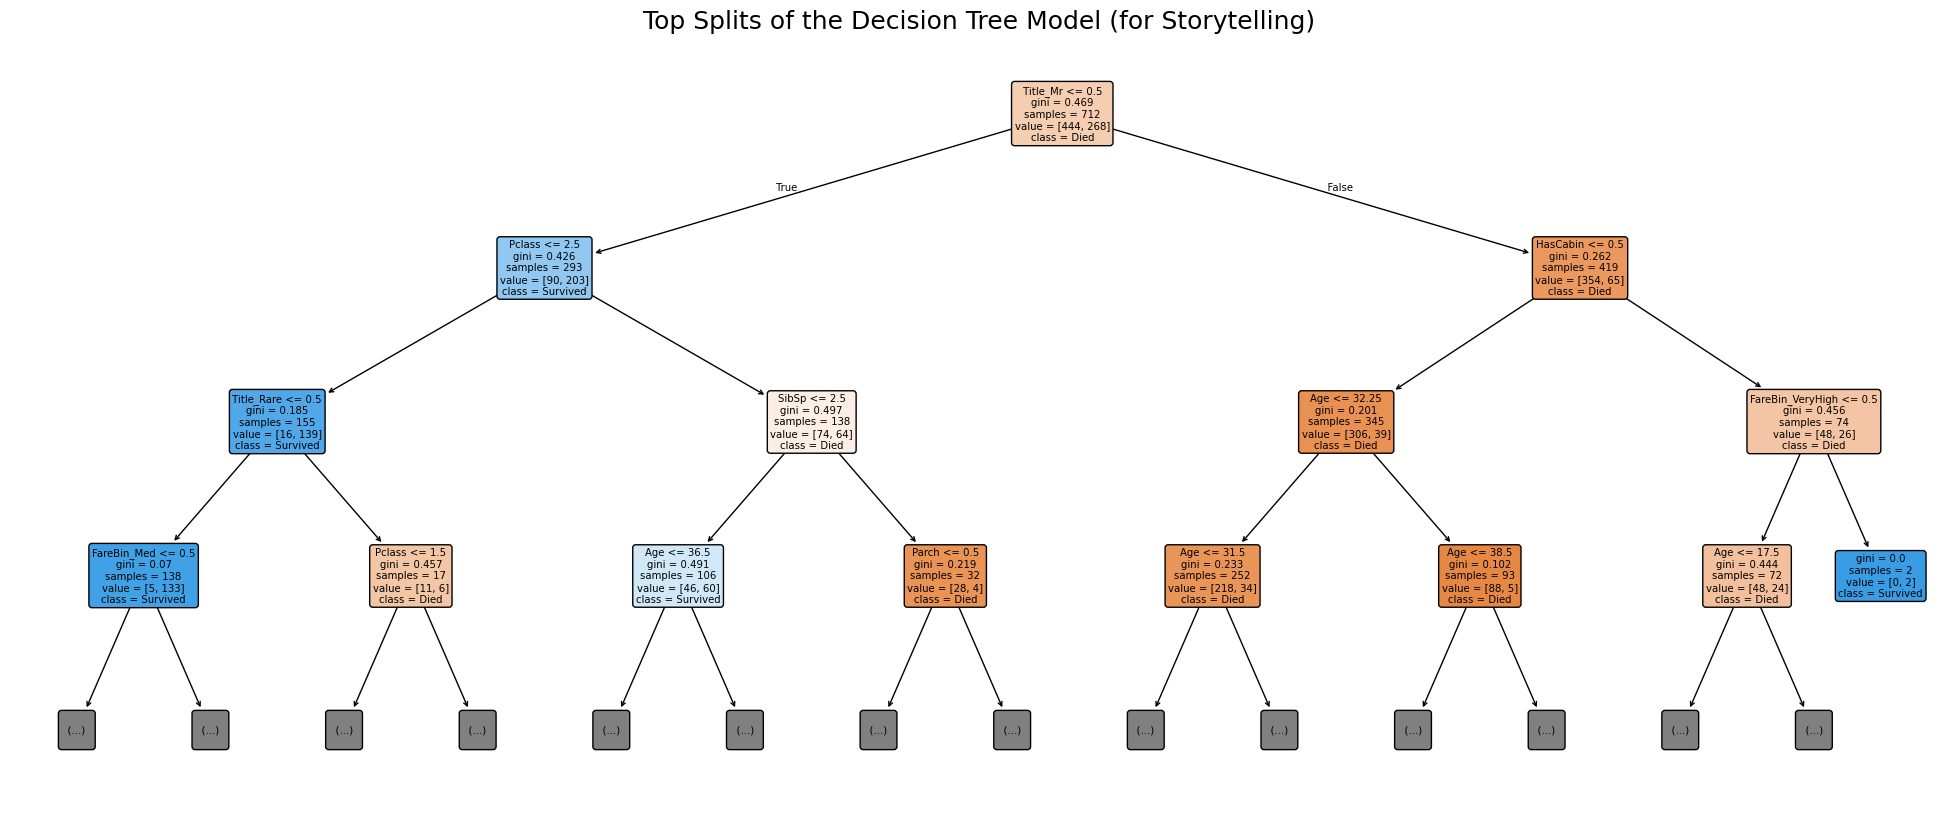

In [11]:
#: Hyperparameter Tuning with Cross-Validation ---
print("--- 1. Hyperparameter Tuning (Random Forest) ---")

# 🎯 Upskilling Goal: Use a Pipeline to combine Scaler and Model, preventing data leakage
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', RandomForestClassifier(random_state=42))
])

# Define the grid of parameters to search over
param_grid = {
    'clf__n_estimators': [50, 100, 200],  # How many trees to build
    'clf__max_depth': [5, 8, 12],         # Restrict depth to avoid overfit
    'clf__min_samples_split': [2, 5]      # Minimum samples for a split
}

# 🎯 Upskilling Goal: Explicitly define K-Fold CV strategy
cv_strategy = KFold(n_splits=5, shuffle=True, random_state=42)

# Set up GridSearchCV using F1 score (the desired metric)
grid_search = GridSearchCV(
    pipe,
    param_grid,
    cv=cv_strategy, # Use the robust K-Fold strategy
    scoring='f1',    # Optimise for F1-Score
    n_jobs=-1        # Use all available CPU cores
)

# Fit the grid search (this runs all 18 combinations * 5 folds)
grid_search.fit(X_train, y_train)

# --- STEP 3: Optimized Model Evaluation ---
best_rf_model = grid_search.best_estimator_
y_pred_best = best_rf_model.predict(X_test)

best_f1 = f1_score(y_test, y_pred_best)
best_accuracy = accuracy_score(y_test, y_pred_best)

print("\n--- 2. Best Random Forest Model Performance (Tuned) ---")
print(f"Best CV F1 Score (Validation Set): {grid_search.best_score_:.4f}")
print(f"Test Accuracy: {best_accuracy:.4f}")
print(f"Test F1-Score: {best_f1:.4f}")
print("Best Parameters:")
print(grid_search.best_params_)
print("-" * 40)


# --- STEP 4: Model Interpretation (Visualization) ---
print("--- 3. Decision Tree Visualization ---")
# Re-train the original best performing model (Decision Tree) for visualization
dt_model = DecisionTreeClassifier(max_depth=5, random_state=42)
dt_model.fit(X_train, y_train)

# 🎯 Upskilling Goal: Visualize the model's logic for the story
plt.figure(figsize=(25, 10))
plot_tree(
    dt_model,
    feature_names=X_encoded.columns.tolist(),
    class_names=['Died', 'Survived'],
    filled=True,
    rounded=True,
    max_depth=3 # Limit depth for a clear, readable story for your presentation
)
plt.title('Top Splits of the Decision Tree Model (for Storytelling)', fontsize=18)
plt.show() #